In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

### Загрузим уже обработанные в прошлом ДЗ данные!

In [2]:
df = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd())) + '/' + 'processed_sigma.csv')
df = df.drop("Trip_ID", axis=1)

X = df.drop("Surge_Pricing_Type", axis=1)
y = df["Surge_Pricing_Type"]

### Principal component analysis (PCA)

**Задание 1.** Спроецируйте данные на двумерную плоскость, используя `PCA`. Другими словами, выделите первые две главные компоненты и изобразите данные в осях этих компонент. Не забудьте центрировать признаки перед применением метода. 

**Какую долю изначальной дисперсии (информации) содержат/объясняют в себе обе компоненты?** Для этого воспользуйтесь атрибутом `explained_variance_ratio_` у PCA-класса.

In [4]:
### Центрируем данные

### Your code is here

X_centered = X - X.mean()

In [11]:
from sklearn.decomposition import PCA

### Your code is here
pca = PCA(n_components=2)

pca_df = pd.DataFrame(pca.fit_transform(X_centered), columns=['PCA1', 'PCA2'])

pca.explained_variance_ratio_

array([0.63176117, 0.21129863])

**Задание 2.** Изобразите heatmap корреляции изначальных признаков с новыми двумя главными компонентами. \
**Какие признаки коррелируют с первой компонентой? Какие со второй? В качестве порогового значения договоримся о корреляции >= 0.5 по абсолютному значению **


<AxesSubplot:>

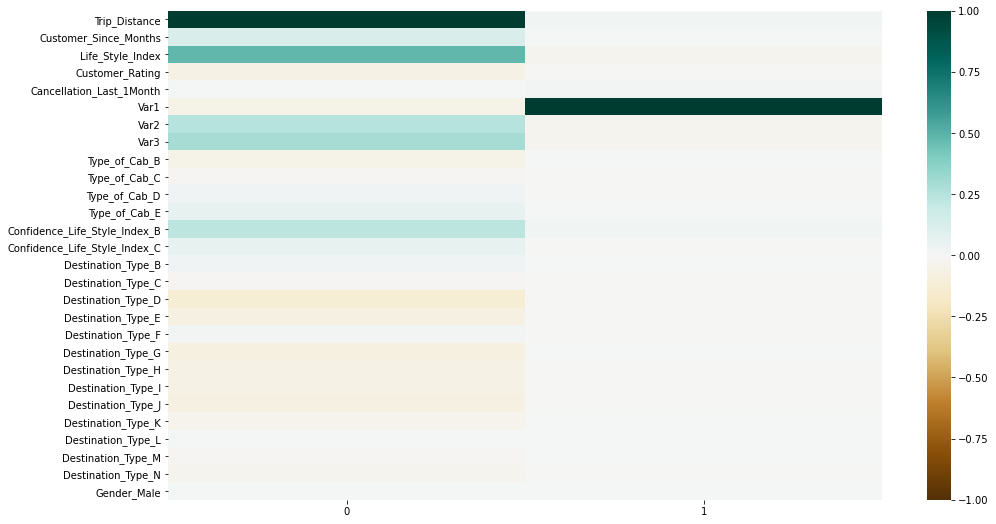

In [27]:
### Your code is here
corr_table = pd.concat((X_centered.corrwith(pca_df['PCA1']), X_centered.corrwith(pca_df['PCA2'])), axis=1)

fig = plt.figure(figsize=(16, 9))
sns.heatmap(corr_table, xticklabels=corr_table.columns, yticklabels=corr_table.index, cmap='BrBG', vmax=1, vmin=-1)

**Задание 3.** Изобразите двумерную проекцию данных с метками классов. Выделите третью главную компоненту и аналогично нарисуйте трехмерную проекцию с метками классов. \
**Какие признаки коррелируют с третьей компонентой?**

In [28]:
### Your code is here

pca = PCA(n_components=3)

pca_df = pd.DataFrame(pca.fit_transform(X_centered), columns=['PCA1', 'PCA2', 'PCA3'])

pca.explained_variance_ratio_


array([0.63176117, 0.21129863, 0.13025786])

<AxesSubplot:>

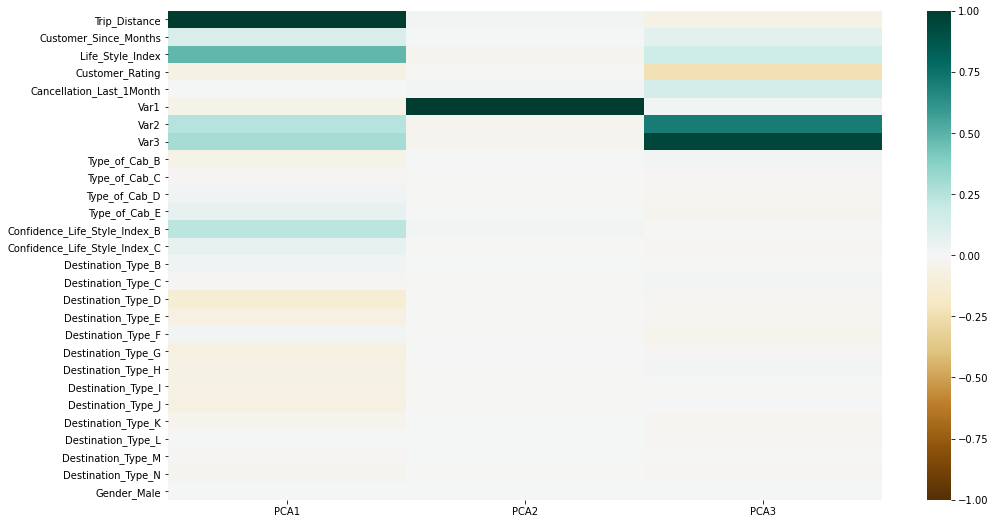

In [35]:
corr_table = pd.concat((pd.concat((X_centered.corrwith(pca_df['PCA1']), X_centered.corrwith(pca_df['PCA2'])), axis=1), X_centered.corrwith(pca_df['PCA3'])), axis=1)

fig = plt.figure(figsize=(16, 9))
sns.heatmap(corr_table, xticklabels=pca_df.columns, yticklabels=corr_table.index, cmap='BrBG', vmax=1, vmin=-1)

Советуем еще и замерить попарные корреляции между главными компонентами! Это поможет в ответе на один из тестовых вопросов.

In [39]:
### Your code is here
pca_df.corr()


,PCA1,PCA2,PCA3
PCA1,1.000000e+00,-7.815425e-18,1.090436e-17
PCA2,-7.815425e-18,1.000000e+00,2.196532e-16
PCA3,1.090436e-17,2.196532e-16,1.000000e+00


**Задание 4.** Обучите логистическую регрессию на первых двух компонентах центрированных данных и подберите гиперпараметры. Обучите логистическую регрессию на центрированных данных и подберите гиперпараметры. **Сравните метрику accuracy и f1-score на тестовой выборке в двух моделях**.

P.S. для удобства, скорости и нормализации данных (понадобится, так как захотим повалидироваться на параметрах регуляризации) можно построить конструкцию Pipeline c 3 следующими степами: StandardScaler -> PCA -> LogisticRegression

In [40]:
np.random.seed(2022)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_centered, y, test_size=0.2, 
                                                    shuffle=True, random_state=2022)

In [48]:
### Your code is here

param_grid = {'model__penalty': ['l1', 'l2', 'elasticnet'],
              'model__C': [1e-5, 0.0001, 0.001, 0.01]}

pipe = Pipeline([('scaler', StandardScaler()), 
                ('pca', PCA(n_components=2)),
                ('model', LogisticRegression())])

search = GridSearchCV(pipe, param_grid, scoring='accuracy')
search.fit(X_train, y_train)

print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.000     0.000     0.000      5372
           2      0.478     0.698     0.568     11349
           3      0.496     0.503     0.500      9612

    accuracy                          0.485     26333
   macro avg      0.325     0.401     0.356     26333
weighted avg      0.387     0.485     0.427     26333



Кажется, достаточно сильно теряем в качестве! Может, добавить компонент?

**Задание 5.** Обучите модели логистической регресии на нескольких различных компонентах: [2, 4, 8, 16, 28]. **Нарисуйте графики зависимости accuracy, f1-score от количества компонент. Введите их значения через запятую**. При обучении используйте l2-регуляризацию, гиперпараметр C подбирайте по сетке. 


In [45]:
### Чтобы не заставлять вас писать похожий на предыдущий код,
### Написали функцию, которая будет обучать модель для
### произвольного числа n_components главных компонент.

def train_pca_i(n_components, X_train, y_train):
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('pca', PCA(n_components=n_components)),
                     ('model', LogisticRegression(penalty='l2', solver='saga',random_state=1))])
    
    param_grid = {'model__C': [0.0001, 0.001, 0.01, 0.1]}
    
    grid = GridSearchCV(pipe, param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    report = classification_report(y_test, grid.predict(X_test), output_dict=True)
    return (report['accuracy'], 
            report['weighted avg']['f1-score'])

In [46]:
%%time
accuracy_dict, f1_score_dict = {}, {}
components_list = [2, 4, 8, 16, 28]

for n_components in components_list:
    ### Your code is here
    accuracy_dict[n_components], f1_score_dict[n_components] = train_pca_i(n_components, X_train, y_train)

CPU times: user 5min 46s, sys: 2min 59s, total: 8min 46s
Wall time: 5min 27s


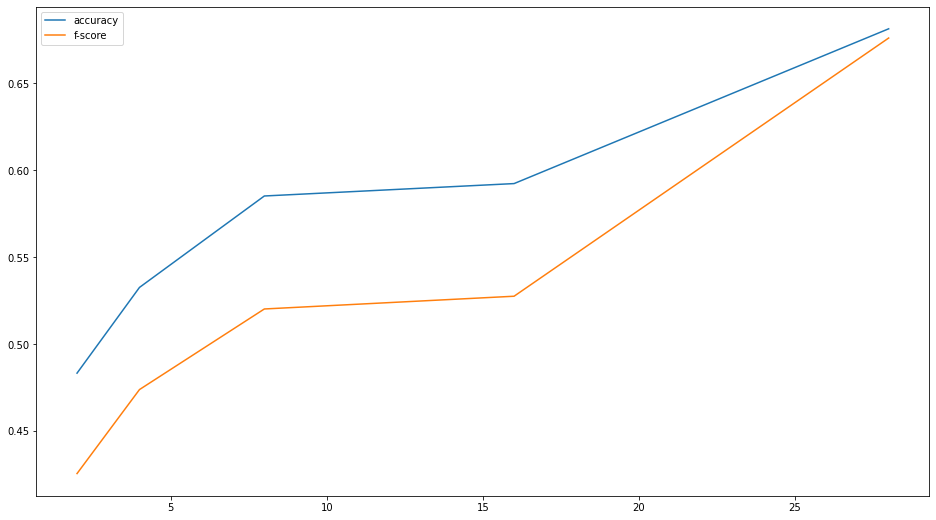

In [54]:
fig = plt.figure(figsize=(16,9))  
plt.plot(accuracy_dict.keys(), accuracy_dict.values(), label='accuracy')
plt.plot(f1_score_dict.keys(), f1_score_dict.values(), label='f-score') 
plt.legend()
plt.show()

In [55]:
accuracy_dict, f1_score_dict

({2: 0.483195989822656,
  4: 0.5325257281737743,
  8: 0.5851593058139977,
  16: 0.5922986366916037,
  28: 0.6813883720047089},
 {2: 0.42539601180945336,
  4: 0.47373121331460993,
  8: 0.5201254610241981,
  16: 0.5274627898778056,
  28: 0.6760757307801638})

Обычно, когда решается какая-то высокоразмерная предсказательная задача, где тысячи признаков, функция качества PCA моделей похожа на параболу ветвями вниз в зависимости от количества компонент (для совсем маленьких и больших n_component качество маленькое, при этом есть где-то промежуточное значение).

Как думаете, почему здесь у нас непрерывно растущие графики качества?

Может, изначальные признаки были слишком хороши?

### t-SNE

Напомним, что метод заключается в введении некоторых функций, основанных на расстоянии между признаками, которые измеряют близость объектов. Функций, как вы помните, две, и они заданы в исходном и новом пространствах соотвественно. Далее минимизируем дивергенцию Кульбака-Лейблера по координатaм в новом пространстве

**Задание 6.** Обучите t-sne c `n_components=2` на изначальных данных и визуализируйте результаты с учетом известных классов. 

P.S. если устанете ждать обучения TSNE, или упадет ошибка по типу oom, то можно сократить число объектов в датасете до, например, пары тысяч. Это и следующее задания никак проверяться системой не будут. Вам достаточно повторить упражнение с практики и получить какое-то более адекватное (по сравнению с PCA) изображение классов.

In [6]:
from sklearn.manifold import TSNE

### Your code is here



**Задание 7.** Обучите t-sne с `n_components=3` на изначальных данных и визуализируйте результаты с учетом известных классов.

In [7]:
### Your code is here



Советуем обрезать датасет до маленького числа объектов (чтобы точки и их группки были хорошо различимы) и поиграться с гиперпараметрами класса Tsne! Обычно такая "игра" может привести к куда более красивым результатам по сравнению с теми, что получены с дефолтными настройками!